In [1]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

!pip install rasterio

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 28 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (55.7 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 132681 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1

     |████████████████████████████████| 2.8MB 2.8MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702070 sha256=79287e2efd69c6ca3a4edebcb2d92704b6180e9259a1266896d72ee64ee5da32
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 2.4.0
    Uninstalling pyproj-2.4.0:
      Successfully uninstalled pyproj-2.4.0
     |████████████████████████████████| 15.1MB 161kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  libproj-dev proj-bin
0 upgraded, 2 newly installed, 0 to remove and 28 not upgraded.
Need to get 232 kB of archives.
After this operation, 1,220 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import rasterio
import gdal

from pyproj import Proj, transform
from scipy.io import loadmat
 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.basemap import Basemap

from numpy import meshgrid
import pandas as pd
import seaborn as sns
%matplotlib inline

In [6]:
dset_gtiff = "/content/drive/My Drive/Data/gpw_v4_population_count_rev11_2020_2pt5_min.tif"
gdal.AllRegister()
global ds
ds = gdal.Open(dset_gtiff)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
ds_size = arr.shape
if band.GetMinimum() is None or band.GetMaximum() is None:
   band.ComputeStatistics(0)
      
print ("[ NO DATA VALUE ] = ", band.GetNoDataValue()) # none
print ("[ MIN ] = ", band.GetMinimum())
print ("[ MAX ] = ", band.GetMaximum())
print (ds_size)

ds.GetProjection()
dataGTIFF = ds.ReadAsArray()

[ NO DATA VALUE ] =  -3.4028230607370965e+38
[ MIN ] =  0.0
[ MAX ] =  1710353.125
(4320, 8640)


### Visualization of GeoTiff Dataset

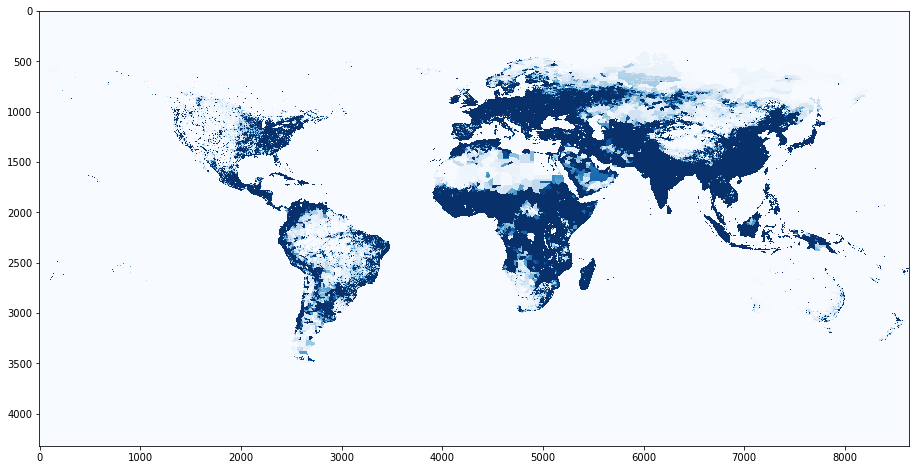

In [7]:
palette = plt.cm.Blues
palette.set_bad('808E94',0.75)

m = np.ma.array(dataGTIFF, mask=np.isnan(dataGTIFF))

plt.figure(figsize = (16,8))
plt.imshow(dataGTIFF, cmap = palette)
plt.clim(0, 100)
plt.show()


### From Documentation
The population count data are divided by the land area data to create the population density rasters for each respective year. The pixels used in GPWv4 are quadrilaterals and therefore the area of each pixel decreases with increasing latitude. Additionally, the pixels in the land area data that include water reflect the net land area (total area of pixel – area of water within the pixel). This means that the population density data cannot be multiplied by a fixed land area size to estimate population totals without introducing error in some or all of the pixels. Multiplying the population density values by pixel area will overestimate population in pixels that contain water. If a fixed value for pixel area is used, it will also over or underestimate population totals for pixels that are all land as the area of these pixels varies by latitude. The population density data are best used to determine statistics (minimum, maximum, mean, etc.) within varying geographies. Users who need population totals should use the GPWv4 population count data.

In [0]:
def transform_coordinate(j, i, padfTransform):
  Yp = padfTransform[0] + i*padfTransform[1] + i*padfTransform[2];
  Xp = padfTransform[3] + j*padfTransform[4] + j*padfTransform[5];
  if Yp < 0:
    Yp += 360
  if Yp > 360:
    Yp -= 360
  return (Xp, Yp)

def population_binning(data, width = 1.25):
  pop_bins = np.zeros((int(90/width), int(280/width)))
  for i in range(len(data) // 2):
    for j in range(len(data[i])):
      coords = transform_coordinate(i, j, ds.GetGeoTransform())
      try:
        if (0 <= coords[0] <= 90) and (0 <= coords[1] <= 280) and data[i][j] >= 1:
          pop_bins[int(coords[0] / width)][int(coords[1] / width)] += round(data[i][j])
      except:
        print(coords)
#   return np.array([[num if num > 1 else float('nan') for num in row] for row in pop_bins])
  return pop_bins
    

### Visualization on the Projection for People-Hours

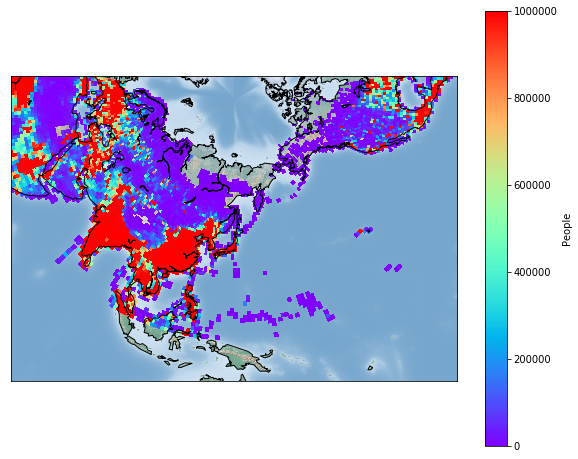

In [0]:
width = 1.25
a = population_binning(dataGTIFF, 1.25)
b = np.array([[float('nan') if num <= 0 else num for num in row] for row in a])
y = np.arange(0,90, width)
x = np.arange(0,280,width)
fig = plt.figure(figsize = (10, 8))
hm = Basemap(projection='lcc', resolution='c',
        width=22E6, height=15E6, 
        lat_0=45, lon_0=140)
hm.shadedrelief(scale = 0.25)
xx,yy = meshgrid(x,y)
hm.pcolormesh(xx,yy, b, latlon=True, cmap='rainbow')
hm.drawcoastlines()
plt.clim(0, 10000000)
plt.colorbar(label='People')

In [0]:
def gather_data():
  all_data = [loadmat('/content/drive/My Drive/Data/TrackData_RMM_phase' + str(i + 1) + '.mat') for i in range(8)]
  eight_phase = []
  for dset in all_data:
    dset_lat = [row for row in dset['latstore']]
    dset_long = [row for row in dset['longstore']]
    hur_path = [zip(dset_lat[a], dset_long[a]) for a in range(4000)]
    eight_phase.append(hur_path)
  return eight_phase

In [0]:
def check_same_bin(x1, y1, x2, y2, width):
  return int(x1/width) == int(x2/width) and int(y1/width) == int(y2/width) 

def popxhours(population, hour_set):
  pop_hour_bins = [population*phase for phase in hour_set]
  pop_hour_bins = [[[float('nan') if np.isnan(num) or num <= 1 else num for num in row] for row in data] for data in pop_hour_bins]
  return np.array(pop_hour_bins)

def make_nans(threeDarr):
  return [[[float('nan') if np.isnan(num) else num for num in row] for row in data] for data in threeDarr]
  
def create_maps(plot_labels, width = 1.25):
  arr_with_nans = make_nans(plot_labels['data'])
  y = np.arange(0,90, width)
  x = np.arange(0,280,width)
  for i in range(len(arr_with_nans)):
    fig = plt.figure(figsize = (10, 8))
    hm = Basemap(projection='lcc', resolution='c',
            width=21E6, height=10E6, 
            lat_0=35, lon_0=145)
    hm.shadedrelief(scale = 0.125)
    parallels = np.arange(-90, 91, 10)
    hm.drawparallels(parallels, labels = [True, False, False, False])
    meridians = np.arange(0, 361,10)
    hm.drawmeridians(meridians, lables = [False, False, True, True])
    xx,yy = meshgrid(x,y) #the colormap and colorbar will be different depending on anomaly's value
    hm.pcolormesh(xx,yy, arr_with_nans[i], latlon=True, cmap= plot_labels['cmapscheme'])
    hm.drawcoastlines()
    plt.clim(plot_labels['cmapmin'], plot_labels['cmapmax'])
    plt.colorbar(label= plot_labels['cmaplabel'])
    plt.title(plot_labels['label'] + ' - Phase %d' %(i+ 1))

In [0]:
def create_maps_subplotted(population_reference, hour_exposure, hour_anomalies, pop_hours, pop_hours_anomaly, width = 1.25):
  y = np.arange(0,90, width)
  x = np.arange(0,280,width)
  xx,yy = meshgrid(x,y)
  parallels = np.arange(-90, 91, 10)
  meridians = np.arange(0, 361,10)
  pop = np.array([[float('nan') if num <= 0 else num for num in row] for row in population_reference])
  for i in range(8):
    plt.figure(figsize = (45, 30))
    plt.subplot(3,2,1)
    hm = Basemap(projection='lcc', resolution='c',
            width=21E6, height=10E6, 
            lat_0=35, lon_0=145)
    hm.shadedrelief(scale = 0.125)
    hm.drawparallels(parallels, labels = [True, False, False, False])
    hm.drawmeridians(meridians, lables = [False, False, True, True])
    hm.pcolormesh(xx,yy, hour_exposure['data'][i], latlon=True, cmap= hour_exposure['cmapscheme'])
    hm.drawcoastlines()
    plt.clim(hour_exposure['cmapmin'], hour_exposure['cmapmax'])
    plt.colorbar(label= hour_exposure['cmaplabel'])
    plt.title(hour_exposure['label'] + ' - Phase %d' %(i+ 1))
    
    plt.subplot(3,2,2)
    hm = Basemap(projection='lcc', resolution='c',
            width=21E6, height=10E6, 
            lat_0=35, lon_0=145)
    hm.shadedrelief(scale = 0.125)
    hm.drawparallels(parallels, labels = [True, False, False, False])
    hm.drawmeridians(meridians, lables = [False, False, True, True])
    hm.pcolormesh(xx,yy, hour_anomalies['data'][i], latlon=True, cmap= hour_anomalies['cmapscheme'])
    hm.drawcoastlines()
    plt.clim(hour_anomalies['cmapmin'], hour_anomalies['cmapmax'])
    plt.colorbar(label= hour_anomalies['cmaplabel'])
    plt.title(hour_anomalies['label'] + ' - Phase %d' %(i+ 1)) 
    
    plt.subplot(3,2,3)
    hm.shadedrelief(scale = 0.125)
    hm.drawparallels(parallels, labels = [True, False, False, False])
    hm.drawmeridians(meridians, lables = [False, False, True, True])
    hm.pcolormesh(xx,yy, pop_hours['data'][i], latlon=True, cmap= pop_hours['cmapscheme'])
    hm.drawcoastlines()
    plt.clim(pop_hours['cmapmin'], pop_hours['cmapmax'])
    plt.colorbar(label= pop_hours['cmaplabel'])
    plt.title(pop_hours['label'] + ' - Phase %d' %(i+ 1)) 
  
    plt.subplot(3,2,4)
    hm.shadedrelief(scale = 0.125)
    hm.drawparallels(parallels, labels = [True, False, False, False])
    hm.drawmeridians(meridians, lables = [False, False, True, True])
    hm.pcolormesh(xx,yy, pop_hours_anomaly['data'][i], latlon=True, cmap= pop_hours_anomaly['cmapscheme'])
    hm.drawcoastlines()
    plt.clim(pop_hours_anomaly['cmapmin'], pop_hours_anomaly['cmapmax'])
    plt.colorbar(label= pop_hours_anomaly['cmaplabel'])
    plt.title(pop_hours_anomaly['label'] + ' - Phase %d' %(i+ 1))
  
    plt.subplot(3,2,5)
    hm.shadedrelief(scale = 0.125)
    hm.drawparallels(parallels, labels = [True, False, False, False])
    hm.drawmeridians(meridians, lables = [False, False, True, True])
    hm.pcolormesh(xx,yy, pop, latlon=True, cmap= 'YlGn')
    hm.drawcoastlines()
    plt.clim(np.nanmin(pop), 10000000)
    plt.colorbar(label= 'People')
    plt.title('Binned Population') 

In [0]:
def plot_hours(hourset, mean = False):
  phase_plot = [1,2,3,4,5,6,7,8]
  hours = [np.nanmean(phase) if mean else np.nansum(phase) for phase in hourset]
  plt.plot(phase_plot, hours)
  plt.show()

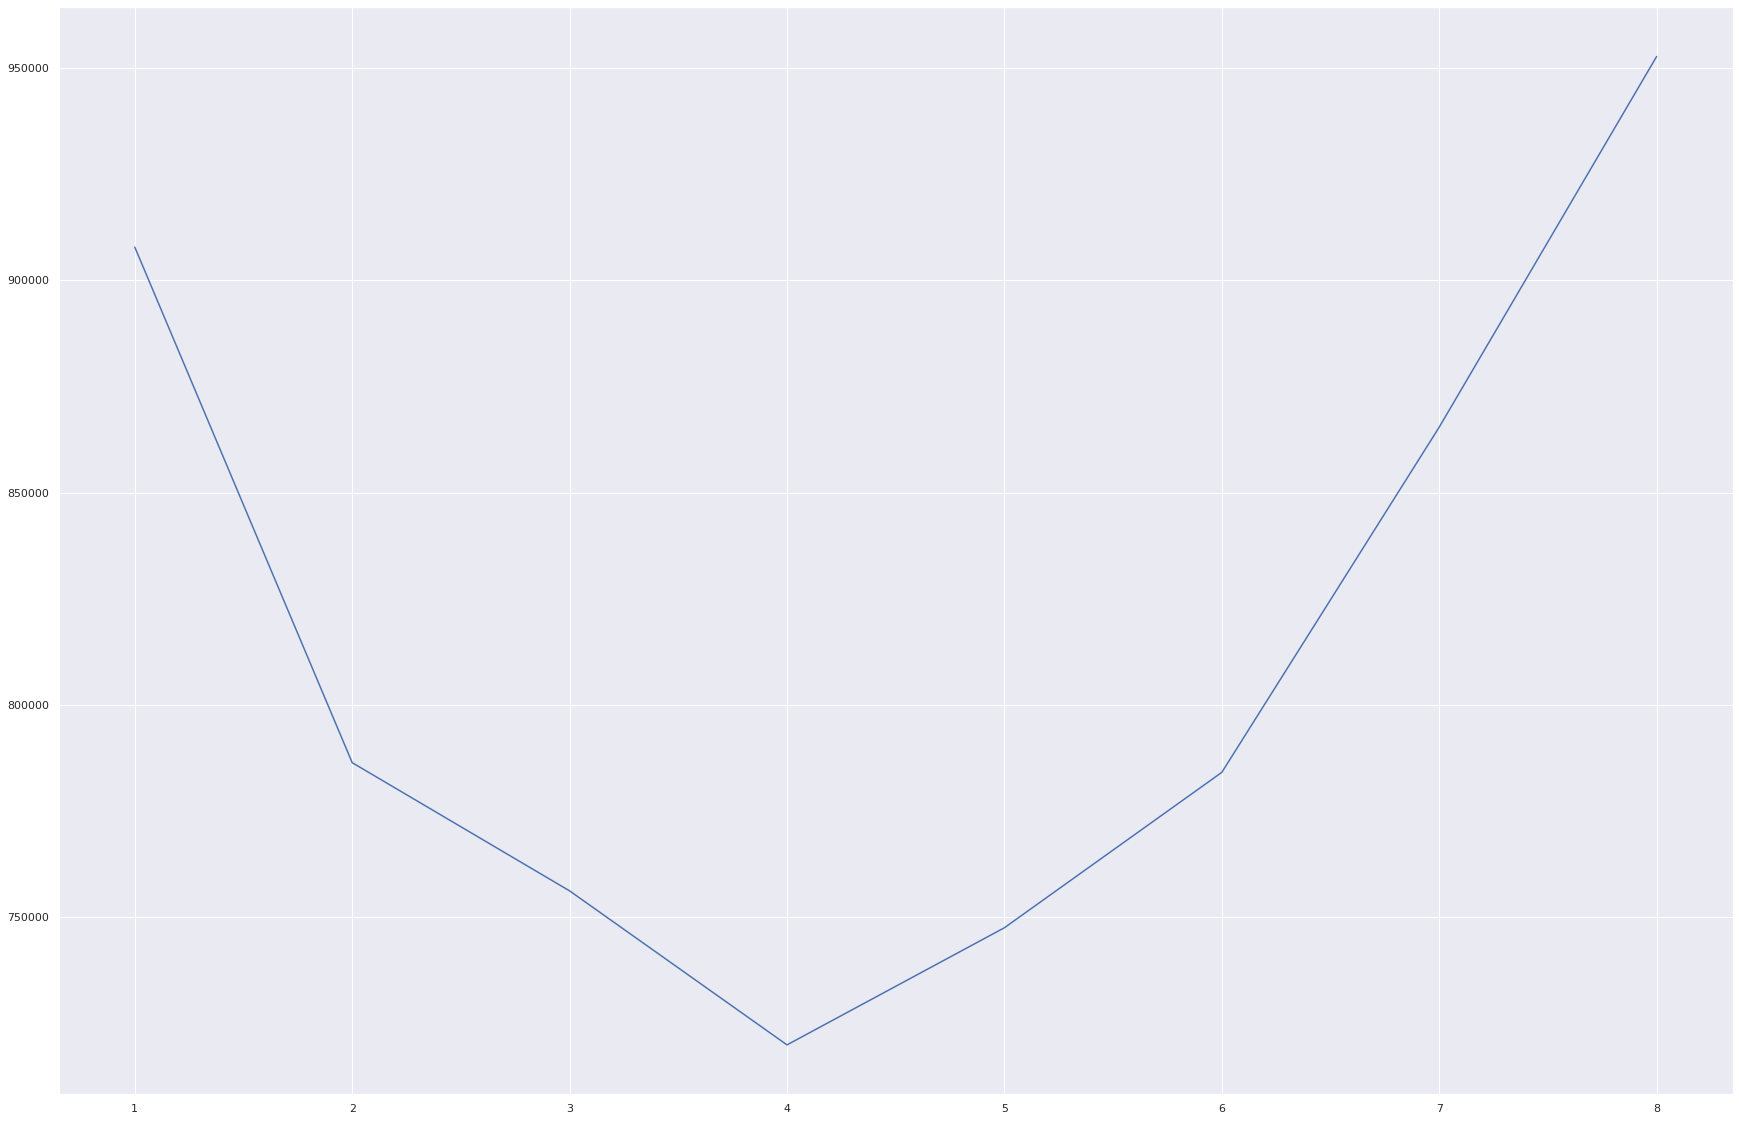

In [0]:
plot_hours(hour_set)

In [0]:
def hour_binning(hurr_phases, width = 1.25):
  all_data = []
  for phase in hurr_phases:
    hour_bins = np.zeros((int(90/width), int(280/width))) #setting up a 2d-array for binning.
    for hurricane in phase:
      hurricane = list(hurricane)
      hurricane = [coord for coord in hurricane if coord[0] != 0. and coord[1] != 0.]
      for i in range(len(hurricane[1:])):
        prev = hurricane[i-1]
        if check_same_bin(prev[0], prev[1], hurricane[i][0], hurricane[i][1], width):
          hour_bins[int(hurricane[i][0]/width)][int(hurricane[i][1] / width)] += 1
        else:
          split_hour(hour_bins, int(prev[0]/width), int(prev[1]/width), int(hurricane[i][0]/width), int(hurricane[i][1]/width))
    all_data.append(hour_bins)
  all_data = np.array([[[float('nan') if num < 1 else num for num in row] for row in data] for data in all_data])
  return all_data

def split_hour(hurr_phases, coord1x, coord1y, coord2x, coord2y):
  dx = coord2x - coord1x
  dy = coord2y - coord1y
  increment = 1 /(abs(dx) + abs(dy))
  incx, incy = 0,0
  hurr_phases[coord1x][coord1y] += increment
  while(dx != 0 or dy != 0):
      if(abs(dx) == abs(dy)):
        while(dx != 0 and dy !=0):
          incx += 1 if dx > 0 else -1
          incy += 1 if dy > 0 else -1
          hurr_phases[coord1x+incx][coord1y+incy] += increment
          dx -= 1 if dx > 0 else -1
          dy -= 1 if dy > 0 else -1
      else:
        if(abs(dx) > abs(dy)):
          incx += 1 if dx > 0 else -1
          dx -= 1 if dx > 0 else -1
          hurr_phases[coord1x+incx][coord1y+incy] += increment
        elif (abs(dy) > abs(dx)):
          incy += 1 if dy > 0 else -1
          dy -= 1 if dy > 0 else -1
          hurr_phases[coord1x+incx][coord1y+incy] += increment

In [0]:
import random
def bootstrap_data(TCphases, samp_size, num_samples, mean = False):
  phase_plot = [1,2,3,4,5,6,7,8]
  dist_data = [[] for i in range(8)]
  for sample in range(num_samples):
    small_phases = []
    for phase in TCphases:
      indicies = random.sample(range(0, len(phase)), samp_size)
      tempset = [phase[index] for index in indicies]
      small_phases.append(tempset)
    sample_bins = hour_binning(small_phases)
    for i in range(len(sample_bins)):
      dist_data[i].append(np.nansum(sample_bins[i]))#/samp_size))
    sum_phase = [np.nansum(phase) for phase in sample_bins]
    plt.plot(phase_plot, sum_phase, linewidth = 0.5)
  plt.show()
  sns.set(rc={'figure.figsize':(30,20)})
  for i in range(len(dist_data)):
    sns.distplot(np.array(dist_data[i]), hist=False, kde_kws={"label": "Phase " + str(i + 1)})
  return dist_data

def distribution_plot(TCphases):
  plt.figure(figsize=(30,20))
  for i in range(len(TCphases)):
    phase = TCphases[i].flatten()
    phase = phase[np.logical_not(np.isnan(phase))]
    sns.set()
    sns.distplot(phase,hist=False,kde=True, kde_kws={"label": "Phase " + str(i + 1)})
#     plt.xlim(-1000, 2500000000)

In [0]:
b = bootstrap_data(gather_data(), 25, 500, True)

In [0]:
distribution_plot(hour_anomaly_plots['data'])

In [0]:
distribution_plot(hour_set_plots['data'])

In [0]:
hour_oned = np.array(hour_set_plots['data']).flatten()
plt.figure(figsize=(30,20))
sns.distplot(hour_oned[np.logical_not(np.isnan(hour_oned))])

In [0]:
phases_no_7 = hour_anomaly_plots['data'][0:6]
phases_no_7.append(hour_anomaly_plots['data'][7])
print(len(phases_no_7))
all_oned = np.array(phases_no_7).flatten()#np.array(hour_anomaly_plots['data'][6]).flatten()
plt.figure(figsize=(30,20))
sns.distplot(all_oned[np.logical_not(np.isnan(all_oned))],bins= 50,hist=False,kde=True, kde_kws={"label": "Phases 1-6, 8"})
seven_oned = np.array(hour_anomaly_plots['data'][6]).flatten()
sns.distplot(seven_oned[np.logical_not(np.isnan(seven_oned))],bins=50,hist=False,kde=True, kde_kws={"label": "Phase 7"})

In [0]:
distribution_plot(hour_anomaly_plots['data'])

In [0]:
 distribution_plot(pop_hours_data['data'])

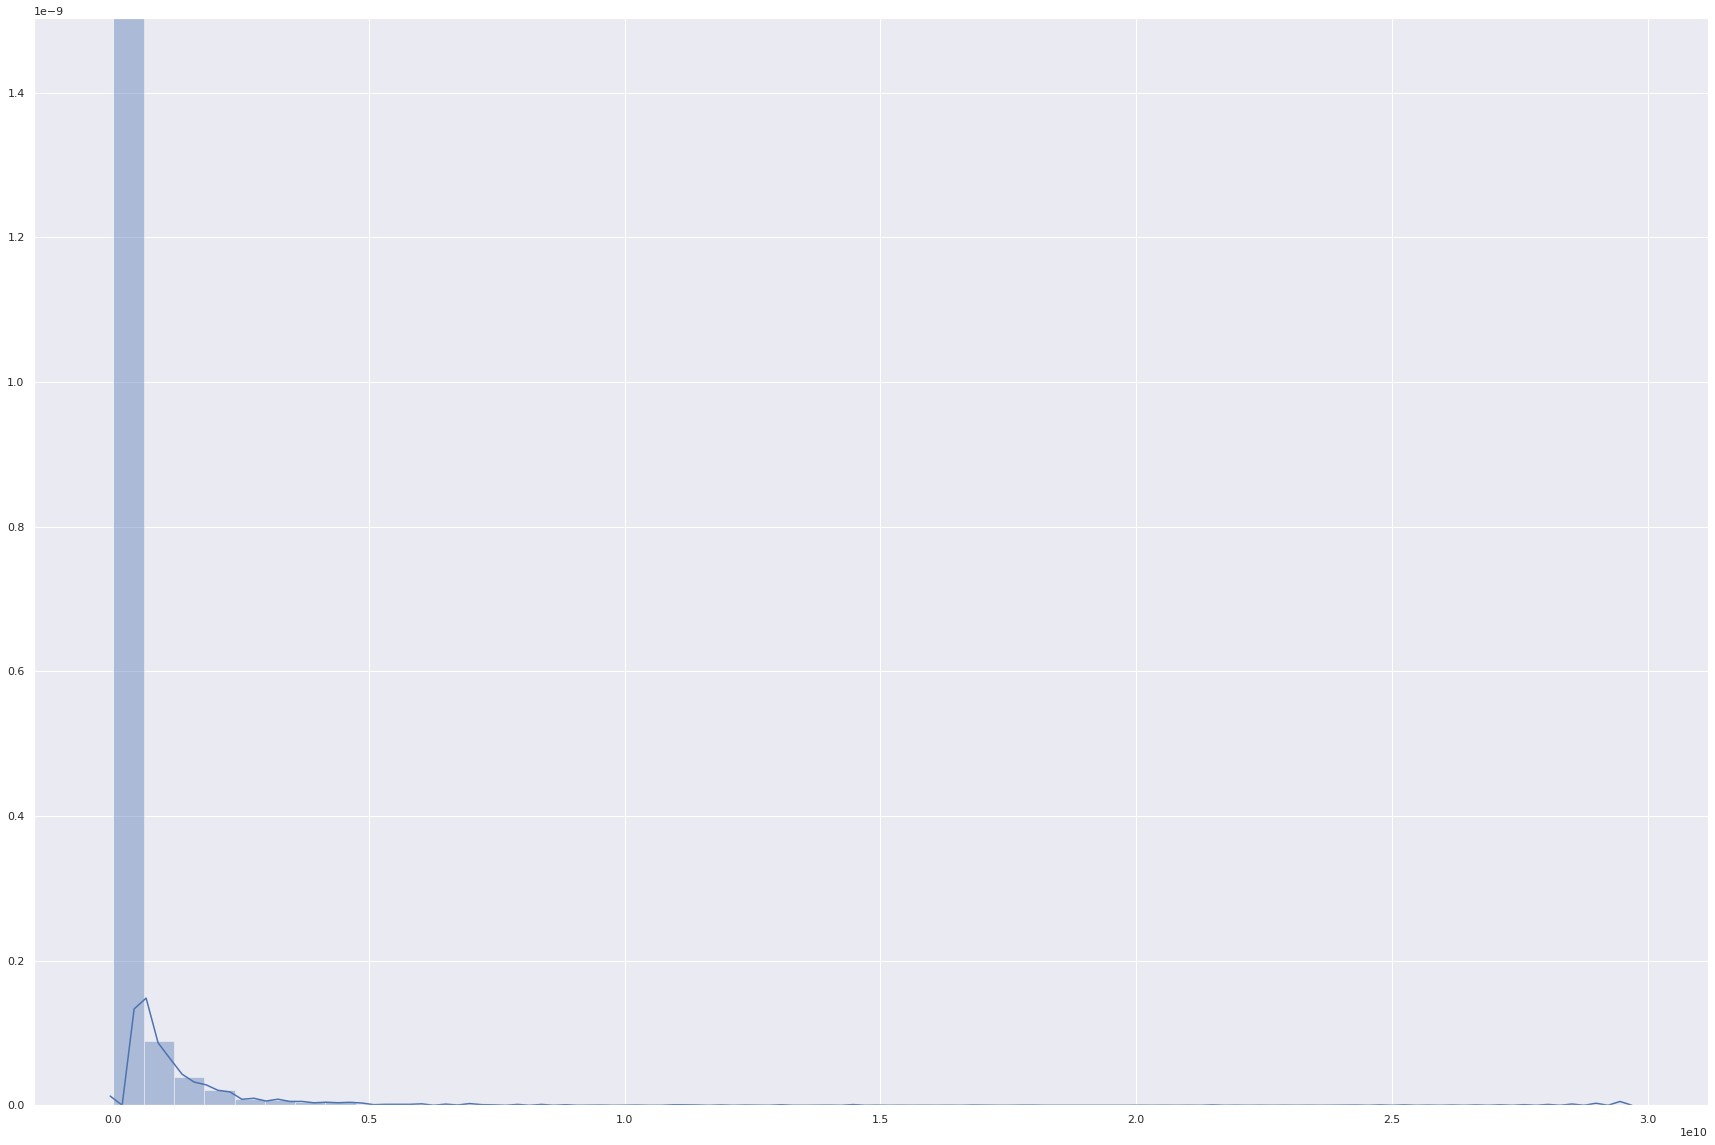

In [24]:
oned_pop_data = np.array(pop_hours_data['data']).flatten()
plt.figure(figsize=(30,20))
sns.distplot(oned_pop_data[np.logical_not(np.isnan(oned_pop_data))])

In [0]:
def data_dict(data = None, label=None, xaxis=None, yaxis=None, cmapscheme=None, cmapmin=None, cmapmax=None, cmaplabel=None):
  ps = {}
  ps['data'] = data
  ps['label'] = label
  ps['xaxis'] = xaxis
  ps['yaxis'] = yaxis
  ps['cmapscheme'] = cmapscheme
  ps['cmapmin'] = cmapmin
  ps['cmapmax'] = cmapmax
  ps['cmaplabel'] = cmaplabel
  return ps

In [0]:
def popxhours_anomaly(pop_hour_bins, percentage = False): 
  sum_pop_hours = np.zeros(pop_hour_bins.shape[1:])
  phases_participated = np.zeros(pop_hour_bins.shape[1:]) #Need to get the number of phases each bin has been in
  for i in range(sum_pop_hours.shape[0]):
    for j in range(sum_pop_hours.shape[1]):
      vals = [phase[i,j] for phase in pop_hour_bins if not np.isnan(phase[i,j])]
      sum_pop_hours[i,j] = np.nansum(vals)
      phases_participated[i,j] = len(vals)
      
  sum_pop_hours = np.array([[sum_pop_hours[i,j] / phases_participated[i,j] if phases_participated[i,j] > 0 else float('nan') for j in range(len(sum_pop_hours[i]))]for i in range(sum_pop_hours.shape[0])])
  all_data = []
  for phase in pop_hour_bins:
    phase_data = np.zeros(pop_hour_bins.shape[1:])
    for i in range(phase_data.shape[0]):
      for j in range(phase_data.shape[1]):
        if not percentage:
          phase_data[i,j] = float('nan') if np.isnan(sum_pop_hours[i,j]) else phase[i,j] - sum_pop_hours[i,j]
        elif percentage and phases_participated[i,j] == 8:
          phase_data[i,j] = float('nan') if np.isnan(sum_pop_hours[i,j]) else phase[i,j] - sum_pop_hours[i,j]
          phase_data[i,j] = phase_data[i,j] * 100 /sum_pop_hours[i,j]
        else:
          phase_data[i,j] = float('nan')
    all_data.append(phase_data)
  return all_data

In [0]:
hour_set = hour_binning(gather_data())
hour_set_plots = data_dict(hour_set,'Hours Exposed', None, None, 'rainbow', np.nanmin(np.array(hour_set)), np.nanmax(np.array(hour_set)), 'Hours')
hour_anom = popxhours_anomaly(hour_set, True)
set_0 = abs(np.nanmax(np.array(hour_anom))) if abs(np.nanmax(np.array(hour_anom))) > abs(np.nanmin(np.array(hour_anom))) else abs(np.nanmin(np.array(hour_anom)))
hour_anomaly_plots = data_dict(hour_anom, 'Hours Exposed Anomaly', None, None, 'RdBu', -set_0, set_0, 'Percent Difference From Mean')
binned_pop = population_binning(dataGTIFF)
all_data = popxhours(binned_pop, hour_set)
pop_hours_data = data_dict(all_data,'Population-Hours', None, None, 'rainbow', np.nanmin(np.array(all_data)), np.nanmax(np.array(all_data)), 'Person-Hours')
anom = popxhours_anomaly(all_data, True)
set_0 = abs(np.nanmax(np.array(anom))) if abs(np.nanmax(np.array(anom))) > abs(np.nanmin(np.array(anom))) else abs(np.nanmin(np.array(anom)))
anomaly_dataset = data_dict(anom, 'Population Hour Anomaly', None, None, 'RdBu', -set_0, set_0, 'Percent Difference From Mean')

In [19]:
h_anom_std = np.nanstd(hour_anomaly_plots['data'])
hour_anomaly_plots['cmapmin'] = -np.nanpercentile(hour_anomaly_plots['data'], 98.75)
hour_anomaly_plots['cmapmax'] =  np.nanpercentile(hour_anomaly_plots['data'], 98.75)
p_anom_std = np.nanstd(anomaly_dataset['data'])
anomaly_dataset['cmapmin'] = -np.nanpercentile(anomaly_dataset['data'], 98.75)
anomaly_dataset['cmapmax'] =  np.nanpercentile(anomaly_dataset['data'], 98.75)

NameError: ignored

In [0]:
create_maps(hour_set_plots) #new hour_binning method

In [0]:
create_maps(hour_anomaly_plots)

In [0]:
create_maps(pop_hours_data)

In [0]:
create_maps(anomaly_dataset)

In [0]:
create_maps_subplotted(binned_pop, hour_set_plots, hour_anomaly_plots, pop_hours_data, anomaly_dataset)

In [0]:
from google.colab import files
#create_maps_subplotted(binned_pop, hour_set_plots, hour_anomaly_plots, pop_hours_data, anomaly_dataset)
create_maps(anomaly_dataset)
#all lines (besides the last line) must be uncommented to create the video
#in the next code block

figures=[manager.canvas.figure
       for manager in mpl._pylab_helpers.Gcf.get_all_fig_managers()]
for i, figure in enumerate(figures):
  figure.savefig('suplots_%d.png' % i)

In [0]:
create_video('anomaly_dataset')

In [0]:
import cv2
import os
from os.path import isfile, join
# from IPython.display import HTML
# figure out .avi / .mp4 and embedding within IPython file
# desired: create function so that this can be called on certain files
def create_video(videoname):
  image_folder = "/content/"
  video_name = videoname + '.mp4'

  images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
  frame = cv2.imread(os.path.join(image_folder, images[0]))
  height, width, layers = frame.shape

  video = cv2.VideoWriter(video_name, 0, 1, (width,height))

  for image in images:
      video.write(cv2.imread(os.path.join(image_folder, image)))

  cv2.destroyAllWindows()
  video.release()